In [1]:
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')

In [2]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

In [3]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")#chunks={'time':1})

In [4]:
mt_path = "/pub/mariant3/WarmWaterMasses/notebooks/02_mhw_metrics/data_ocetrac-labels/"
blobs = xr.open_dataset(f"{mt_path}/01860503-01901020_ocetrac-labels-region.nc")
labels = blobs.blobs

In [5]:
event = (labels==26).any("time")

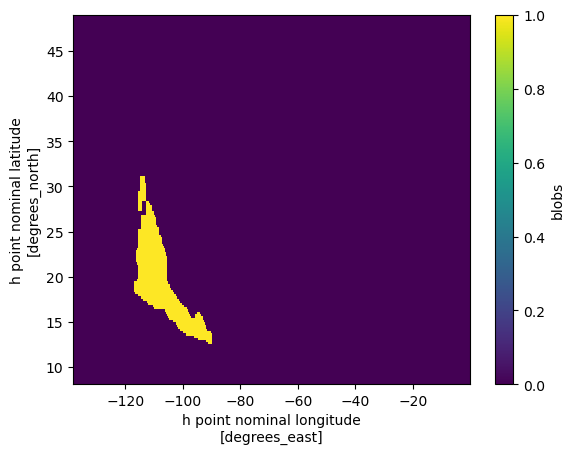

In [6]:
event.plot()

In [7]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])
ds

<xarray.Dataset>
Dimensions:                         (time: 1459, xh: 269, yh: 130, zl: 75,
                                     xq: 270, yq: 131, time_bounds: 1460)
Coordinates:
  * time                            (time) object 0186-01-02 12:00:00 ... 018...
  * xh                              (xh) float64 -137.9 -137.7 ... -70.16 -69.91
  * yh                              (yh) float64 10.2 10.44 ... 38.87 39.07
  * zl                              (zl) float64 1.0 3.0 ... 3.591e+03 5.111e+03
  * xq                              (xq) float64 -137.8 -137.6 ... -69.76 -69.51
  * yq                              (yq) float64 10.32 10.56 ... 39.16 39.36
  * time_bounds                     (time_bounds) object 0186-01-02 00:00:00 ...
Data variables: (12/27)
    S_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_adx                           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 130, 270), meta=np.ndarray>
    T_ady                           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 131, 269), meta=np.ndarray>
    Th_tendency_vert_remap          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    boundary_forcing_h_tendency     (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    ...                              ...
    wfo                             (time, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
    rhopot2_bounds                  (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thetao_bounds                   (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    volcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    zos_bounds                      (time_bounds, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
Attributes:
    filename:          01860101.ocean_daily.nc
    title:             CM4_piControl_C_restartyear186
    associated_files:  areacello: 01860101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           Wed Mar 20 15:17:19 2024: ncks -v S_advection_xy -d xh...
    NCO:               netCDF Operators version 5.0.1 (Homepage = http://nco....

In [8]:
ds = xr.merge([static,ds],join='inner')

In [9]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

In [10]:
ds = add_estimated_layer_interfaces(ds)

In [11]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ds["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(ds["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(ds["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
}
#'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
#'Z': {'center': 'zl', 'outer': 'zl'}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(zl=0)
#ds['sos'] = ds['so'].isel(zl=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [12]:
wm = xwmt.WaterMass(grid)

In [13]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
del budgets_dict['salt']['lhs']
del budgets_dict['salt']['rhs']

In [14]:
xbudget.collect_budgets(grid, budgets_dict)

In [15]:
budgets_dict;

(10.0, 38.0)

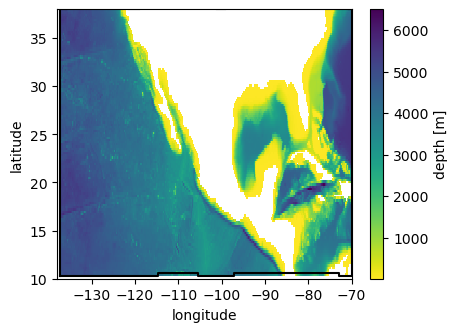

In [16]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

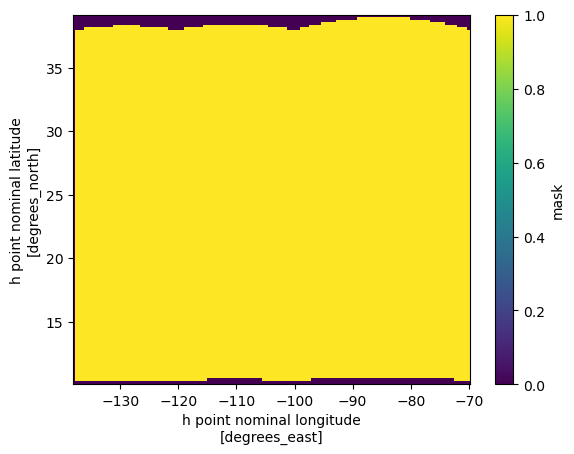

In [17]:
manso_region.mask.plot()

In [18]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        event #instead of manso_region.mask
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True)
    wmtcalc = wmb.wmt

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'xh' ('xh',)